In [13]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [14]:
train_data=datasets.MNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download=True
)

In [15]:
test_data=datasets.MNIST(
    root='data',
    train=0,
    transform=ToTensor(),
    download=True
)

In [17]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [18]:
from torch.utils.data import DataLoader

loaders={
    'train': DataLoader(train_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),
    'test': DataLoader(test_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),
}

In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [20]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()

    self.conv1=nn.Conv2d(1,10,kernel_size=5)
    self.conv2=nn.Conv2d(10,20,kernel_size=5)
    self.fc1=nn.Linear(320,50)
    self.fc2=nn.Linear(50,10)

  def forward(self,x):
    x= F.relu(F.max_pool2d(self.conv1(x),2))
    x= F.relu(F.max_pool2d(self.conv2(x),2))
    x= x.view(-1,320)
    x= F.relu(self.fc1(x))
    x= self.fc2(x)

    return F.softmax(x)


In [24]:
import torch
import copy

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

model=CNN().to(device)

optimizer=optim.Adam(model.parameters(),lr=0.001)

loss_fn=nn.CrossEntropyLoss()

accarr=[]
def train(ep):
  model.train()

  for bid,(im, lab) in enumerate(loaders['train']):
    im=im.to(device)
    lab=lab.to(device)
    optimizer.zero_grad()

    out=model(im)
    loss=loss_fn(out,lab)
    loss.backward()
    optimizer.step()
    accuracy=(out.argmax(dim=1)==lab).float().mean()
    #print(f"{ep}-{bid}-{accuracy}")

    accarr.append(accuracy)
  return accuracy



In [25]:
for i in range(1,11):
  acc=train(i)
  print(f"{i}-{acc}")

<ipython-input-20-7e9a46849242>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


1-0.9300000071525574
2-0.9700000286102295
3-0.9800000190734863
4-0.9800000190734863
5-0.9900000095367432
6-0.9800000190734863
7-0.9800000190734863
8-0.9800000190734863
9-0.9900000095367432
10-0.9900000095367432


In [28]:
def test():
  model.eval()

  acc=[]
  loss=[]
  with torch.no_grad():
    for im,lab in loaders['test']:
      out=model(im)
      loss.append(loss[-1]+loss_fn(out,lab).item())
      acc.append((out.argmax(dim=1)==lab).float().mean())
  return loss,acc


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-20-7e9a46849242>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


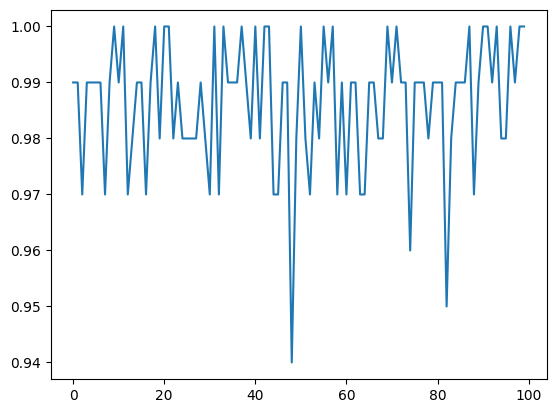

In [30]:
loss,acc=test()

import matplotlib.pyplot as plt
#plt.plot(loss)
plt.plot(acc)